In [14]:
import pandas as pd
import numpy as np

df_raw = pd.read_csv("data/physiological_cycles.csv")
df_raw.head()

,Cycle start time,Cycle end time,Cycle timezone,Recovery score %,Resting heart rate (bpm),Heart rate variability (ms),Skin temp (celsius),Blood oxygen %,Day Strain,Energy burned (cal),...,Asleep duration (min),In bed duration (min),Light sleep duration (min),Deep (SWS) duration (min),REM duration (min),Awake duration (min),Sleep need (min),Sleep debt (min),Sleep efficiency %,Sleep consistency %
0,2025-06-03 22:46:12,NaN,UTC-04:00,86.0,49.0,58.0,33.96,95.47,NaN,NaN,...,442.0,459.0,190.0,83.0,169.0,17.0,449.0,127.0,96.0,74.0
1,2025-06-02 23:32:17,2025-06-03 22:46:12,UTC-04:00,16.0,52.0,50.0,34.61,94.80,9.0,2269.0,...,167.0,168.0,63.0,50.0,54.0,1.0,563.0,88.0,99.0,89.0
2,2025-06-01 22:42:02,2025-06-02 23:32:17,UTC-04:00,75.0,50.0,59.0,34.29,96.93,12.5,2645.0,...,415.0,437.0,210.0,89.0,116.0,22.0,553.0,70.0,95.0,90.0
3,2025-05-31 23:42:21,2025-06-01 22:42:02,UTC-04:00,78.0,51.0,61.0,33.82,97.56,14.1,2909.0,...,373.0,390.0,138.0,103.0,132.0,17.0,514.0,38.0,95.0,82.0
4,2025-05-30 22:49:13,2025-05-31 23:42:21,UTC-04:00,58.0,54.0,51.0,32.84,97.06,12.8,2830.0,...,405.0,460.0,188.0,110.0,107.0,55.0,481.0,13.0,88.0,89.0


In [6]:
hr_columns = ["Cycle start time", "Cycle end time", "Resting heart rate (bpm)", 'Heart rate variability (ms)', 'Max HR (bpm)', 'Average HR (bpm)']

Fucking whoop only gives you summaries, not higher resolution.

Why can't people just give you your data?

In [31]:
def prepare_whoop_data_with_dates(df):
    df['date'] = pd.to_datetime(df['Cycle start time'])
    
    features = {
        # Your core metrics
        'resting_hr': df['Resting heart rate (bpm)'],
        'hrv': df['Heart rate variability (ms)'],
        'max_hr': df['Max HR (bpm)'],
        'avg_hr': df['Average HR (bpm)'],
        
        # Rich temporal features from actual dates
        'day_of_week': df['date'].dt.dayofweek,  # 0=Monday, 6=Sunday
        'day_of_month': df['date'].dt.day,
        'month': df['date'].dt.month,
        'is_weekend': df['date'].dt.dayofweek.isin([5, 6]),
        'is_monday': df['date'].dt.dayofweek == 0,  # Monday effect?
        
        # Linear trend (still useful!)
        'days_since_start': (df['date'] - df['date'].min()).dt.days,
        
        # # Cyclical encoding for better periodicity
        # 'day_of_week_sin': np.sin(2 * np.pi * df['date'].dt.dayofweek / 7),
        # 'day_of_week_cos': np.cos(2 * np.pi * df['date'].dt.dayofweek / 7),
        # 'day_of_year_sin': np.sin(2 * np.pi * df['date'].dt.dayofyear / 365),
        # 'day_of_year_cos': np.cos(2 * np.pi * df['date'].dt.dayofyear / 365),
    }
    
    return pd.DataFrame(features)

df = prepare_whoop_data_with_dates(df_raw).dropna()

In [33]:
df.head()

,resting_hr,hrv,max_hr,avg_hr,day_of_week,day_of_month,month,is_weekend,is_monday,days_since_start
1,52.0,50.0,135.0,65.0,0,2,6,False,True,25
2,50.0,59.0,158.0,65.0,6,1,6,True,False,24
3,51.0,61.0,154.0,70.0,5,31,5,True,False,23
4,54.0,51.0,152.0,70.0,4,30,5,False,False,22
5,50.0,56.0,149.0,68.0,3,29,5,False,False,21


In [34]:
# Look for weekly cycles (7-day periods)
fft_resting = np.fft.fft([df['resting_hr']])
frequencies = np.fft.fftfreq(len(df['resting_hr']))

# Find dominant frequencies
weekly_freq = 1/7  # cycles per day
monthly_freq = 1/30

In [35]:
fft_resting

array([[ 1.36900000e+03 +0.j        , -3.65827106e+01 -1.86591809j,
         2.11342555e+00 -1.97982516j,  2.30024338e+01 -6.43375998j,
        -1.99308636e+01-11.19171529j, -2.42035400e-01 +8.68177167j,
         5.19235838e+00 +1.84168971j, -4.04510330e+00 +1.82129871j,
         1.80247481e+01 -5.9949926j , -4.72249885e+00+11.43417289j,
         2.54194067e+01 -1.04905547j, -1.04100857e+01 -3.49206016j,
        -1.98190752e+01 +6.70026317j,  2.70000000e+01 +0.j        ,
        -1.98190752e+01 -6.70026317j, -1.04100857e+01 +3.49206016j,
         2.54194067e+01 +1.04905547j, -4.72249885e+00-11.43417289j,
         1.80247481e+01 +5.9949926j , -4.04510330e+00 -1.82129871j,
         5.19235838e+00 -1.84168971j, -2.42035400e-01 -8.68177167j,
        -1.99308636e+01+11.19171529j,  2.30024338e+01 +6.43375998j,
         2.11342555e+00 +1.97982516j, -3.65827106e+01 +1.86591809j]])

np.fft.fft()

Decomposes our time series into sine and cosine waves of different frequencies
Returns complex numbers representing the amplitude and phase of each frequency component

fftfreq()

Gets the frequencies the complex numbers from fft() represent


In [36]:
frequencies

array([ 0.        ,  0.03846154,  0.07692308,  0.11538462,  0.15384615,
        0.19230769,  0.23076923,  0.26923077,  0.30769231,  0.34615385,
        0.38461538,  0.42307692,  0.46153846, -0.5       , -0.46153846,
       -0.42307692, -0.38461538, -0.34615385, -0.30769231, -0.26923077,
       -0.23076923, -0.19230769, -0.15384615, -0.11538462, -0.07692308,
       -0.03846154])

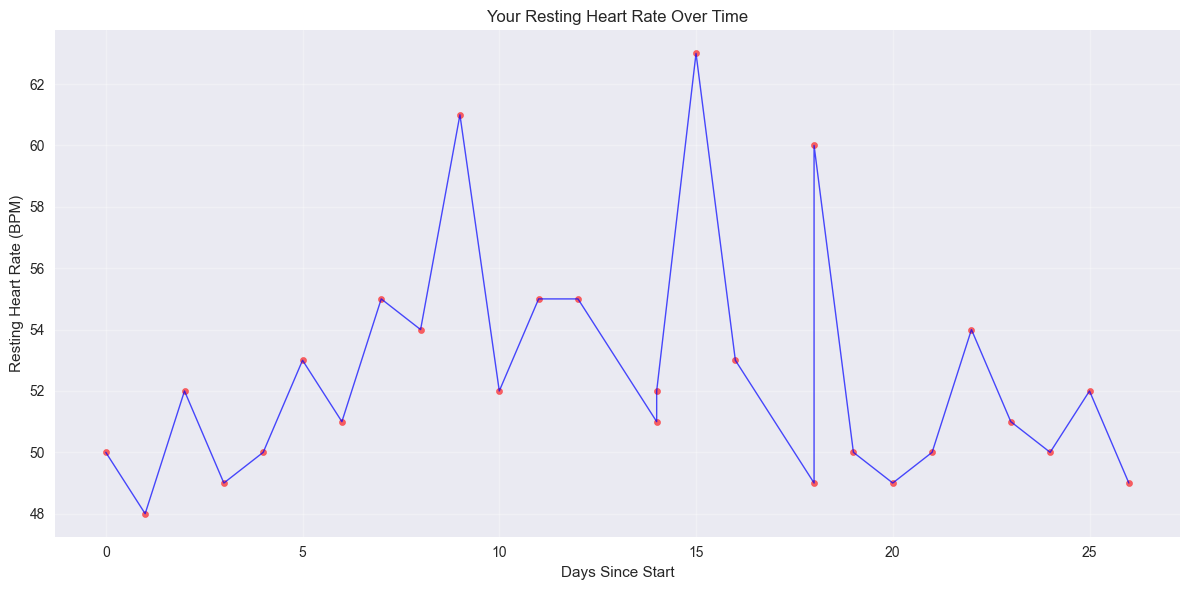

Data span: 28 days
Resting HR range: 48 - 63 BPM


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# First, let's look at our time series data
# We need to sort by date to get proper chronological order
df_sorted = df.sort_values('days_since_start').reset_index(drop=True)

# Create a time series plot of resting heart rate
plt.figure(figsize=(12, 6))
plt.plot(df_sorted['days_since_start'], df_sorted['resting_hr'], 'b-', linewidth=1, alpha=0.7)
plt.scatter(df_sorted['days_since_start'], df_sorted['resting_hr'], c='red', s=20, alpha=0.6)

plt.xlabel('Days Since Start')
plt.ylabel('Resting Heart Rate (BPM)')
plt.title('Your Resting Heart Rate Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Data span: {len(df_sorted)} days")
print(f"Resting HR range: {df_sorted['resting_hr'].min():.0f} - {df_sorted['resting_hr'].max():.0f} BPM")

In [37]:
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Make sure data is sorted chronologically
df_sorted = df.sort_values('days_since_start').reset_index(drop=True)
heart_rate = df_sorted['resting_hr'].values

print(f"Analyzing {len(heart_rate)} daily heart rate measurements")

# Remove the mean (DC component) - this is standard practice
# The FFT will show us variations around your average HR
hr_centered = heart_rate - np.mean(heart_rate)
print(f"Mean resting HR: {np.mean(heart_rate):.1f} BPM")
print(f"Analyzing variations around this mean...")

# Compute the FFT
# This transforms time-domain data (HR vs days) to frequency-domain (power vs frequency)
fft_values = fft(hr_centered)
frequencies = fftfreq(len(heart_rate), d=1.0)  # d=1.0 means 1 day sampling interval

# Calculate power spectrum (magnitude squared)
# This shows how much "energy" is at each frequency
power_spectrum = np.abs(fft_values)**2

print(f"FFT computed - found {len(frequencies)} frequency components")

Analyzing 26 daily heart rate measurements
Mean resting HR: 52.7 BPM
Analyzing variations around this mean...
FFT computed - found 26 frequency components


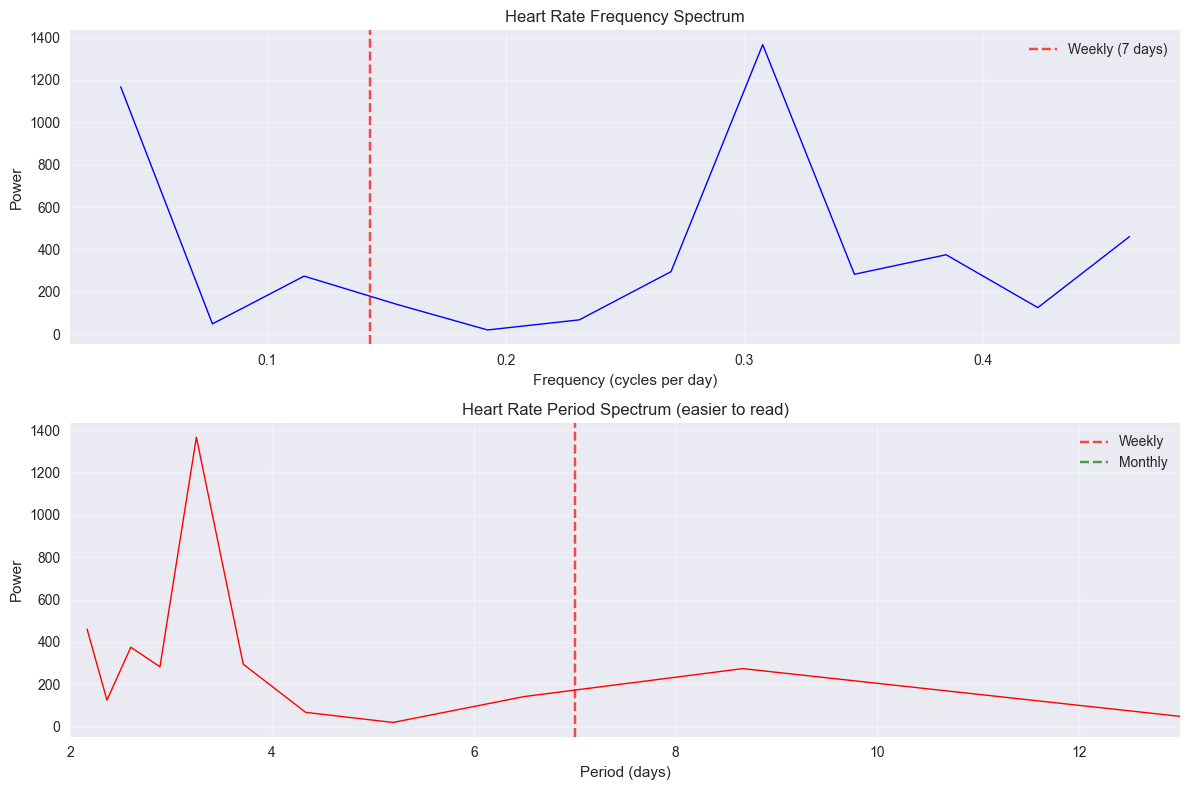

Strongest periodic patterns found:
  Period: 3.2 days (frequency: 0.308 cycles/day), Power: 1366
  Period: 26.0 days (frequency: 0.038 cycles/day), Power: 1168
  Period: 2.2 days (frequency: 0.462 cycles/day), Power: 461
  Period: 2.6 days (frequency: 0.385 cycles/day), Power: 375
  Period: 3.7 days (frequency: 0.269 cycles/day), Power: 295


In [38]:
# Only plot positive frequencies (negative frequencies are mirror images)
positive_freqs = frequencies[frequencies > 0]
positive_power = power_spectrum[frequencies > 0]

# Create the frequency spectrum plot
plt.figure(figsize=(12, 8))

# Top subplot: Power vs Frequency
plt.subplot(2, 1, 1)
plt.plot(positive_freqs, positive_power, 'b-', linewidth=1)
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Power')
plt.title('Heart Rate Frequency Spectrum')
plt.grid(True, alpha=0.3)

# Add vertical lines for common periods
weekly_freq = 1/7  # Weekly pattern
plt.axvline(weekly_freq, color='red', linestyle='--', alpha=0.7, label=f'Weekly (7 days)')
if len(positive_freqs) > 20:  # Only if we have enough data
    monthly_freq = 1/30
    plt.axvline(monthly_freq, color='green', linestyle='--', alpha=0.7, label=f'Monthly (30 days)')
plt.legend()

# Bottom subplot: Same data but vs Period (easier to interpret)
plt.subplot(2, 1, 2)
periods = 1 / positive_freqs  # Convert frequency to period in days
plt.plot(periods, positive_power, 'r-', linewidth=1)
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Heart Rate Period Spectrum (easier to read)')
plt.xlim(2, min(60, len(heart_rate)/2))  # Show periods from 2 days to ~2 months
plt.axvline(7, color='red', linestyle='--', alpha=0.7, label='Weekly')
plt.axvline(30, color='green', linestyle='--', alpha=0.7, label='Monthly')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find the strongest periodic patterns
peak_indices = np.argsort(positive_power)[-5:]  # Top 5 peaks
print("Strongest periodic patterns found:")
for i in reversed(peak_indices):
    freq = positive_freqs[i]
    period = 1/freq
    power = positive_power[i]
    print(f"  Period: {period:.1f} days (frequency: {freq:.3f} cycles/day), Power: {power:.0f}")